In [33]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from mpl_toolkits.mplot3d import Axes3D

import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
spark=SparkSession.builder.appName('unsupervised_learning').getOrCreate()

In [3]:
df=spark.read.csv('music_data.csv',inferSchema=True, header=True)

In [4]:
df.count()

429023

In [5]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- music category: string (nullable = true)



In [6]:
df.select('music category').distinct().count()

21

In [7]:
df.groupBy('music category').count().orderBy('count', ascending=False).show(100,False)

+-----------------+-----+
|music category   |count|
+-----------------+-----+
|Alternative Music|64227|
|Blues            |54647|
|Classical Music  |43117|
|Country Music    |39891|
|Dance Music      |35779|
|Easy Listening   |34356|
|Electronic Music |30985|
|Rap              |29569|
|Hip Hop          |16895|
|Indie Pop        |16244|
|Motivational     |10118|
|Asian Pop        |8444 |
|Jazz             |7685 |
|Latin Music      |7302 |
|New Age          |7053 |
|Opera            |6188 |
|Hindi Music      |5689 |
|Popular          |4729 |
|Soulful          |2403 |
|Reggae           |1970 |
|Rock             |1732 |
+-----------------+-----+



In [8]:
#Data engineering 

#Pivot data on userID
feature_df=  df.stat.crosstab("user_id","music category")

In [9]:
feature_df.show(3,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|
+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7|65               |0        |7    |8              |7            |12         |7             |

In [10]:
feat_cols=[col for col in feature_df.columns if col != 'user_id_music category']

In [11]:
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

In [12]:
final_data = vec_assembler.transform(feature_df)

In [13]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [14]:
scalerModel = scaler.fit(final_data)

In [15]:
cluster_final_data = scalerModel.transform(final_data)

In [54]:
#Kmean model with 6 clusters 
kmeans6 = KMeans(featuresCol='scaledFeatures',k=6)

In [17]:
model_k6 = kmeans6.fit(cluster_final_data)

In [18]:
model_k6.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         4|    3|
|         2|   17|
|         0|  748|
|         1|    1|
|         3|    5|
|         5|    1|
+----------+-----+



In [19]:
model_k6.transform(cluster_final_data).show()

+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|user_id_music category|Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|            features|      scaledFeatures|prediction|
+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|  ca3c4285512798abe...|               65|        0|    7|              8|            7|         12|             7|         

In [55]:
#Prediction on data
cluser_prediction=model_k6.transform(cluster_final_data)

In [21]:
cluser_prediction.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = true)
 |-- Asian Pop: long (nullable = true)
 |-- Blues: long (nullable = true)
 |-- Classical Music: long (nullable = true)
 |-- Country Music: long (nullable = true)
 |-- Dance Music: long (nullable = true)
 |-- Easy Listening: long (nullable = true)
 |-- Electronic Music: long (nullable = true)
 |-- Hindi Music: long (nullable = true)
 |-- Hip Hop: long (nullable = true)
 |-- Indie Pop: long (nullable = true)
 |-- Jazz: long (nullable = true)
 |-- Latin Music: long (nullable = true)
 |-- Motivational: long (nullable = true)
 |-- New Age: long (nullable = true)
 |-- Opera: long (nullable = true)
 |-- Popular: long (nullable = true)
 |-- Rap: long (nullable = true)
 |-- Reggae: long (nullable = true)
 |-- Rock: long (nullable = true)
 |-- Soulful: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- prediction: integer (nullab

In [56]:
#Dimension reduction using PCA
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pca_features")

In [24]:
pca_model = pca.fit(cluser_prediction)

In [25]:
result = pca_model.transform(cluser_prediction).select('user_id_music category',"pca_features",'prediction')

In [26]:
result.show(truncate=False)

+----------------------------------------------------------------+-----------------------------------------------------------------+----------+
|user_id_music category                                          |pca_features                                                     |prediction|
+----------------------------------------------------------------+-----------------------------------------------------------------+----------+
|ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7|[-0.22507350265162823,0.1508289363663225,-0.1392213299780866]    |0         |
|b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4|[-0.5273003162834192,0.10206886950980032,-0.014971360310927027]  |0         |
|a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3|[-0.2396826102029581,0.2801153618243121,-0.17382194436381856]    |0         |
|cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372|[-3.512051591993015,0.3272943318957396,1.1017302617933125]       |0   

In [57]:
#PCA Dataframe to Pandas Dataframe
clusters = result.toPandas().set_index('user_id_music category')

In [29]:
clusters.head(10)

,pca_features,prediction
user_id_music category,,
ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7,"[-0.22507350265162823, 0.1508289363663225, -0....",0
b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4,"[-0.5273003162834192, 0.10206886950980032, -0....",0
a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3,"[-0.2396826102029581, 0.2801153618243121, -0.1...",0
cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372,"[-3.512051591993015, 0.3272943318957396, 1.101...",0
8ab21c1b361d5c4aa1ed01893305febf1c6659bd342217eece1225d789ba57da,"[-0.6796385576703681, 0.3960805354648381, 0.11...",0
34e22754ffec4a0d434edfa0f3b10c0e1ab14c632cee37514076d211cf1e7017,"[-2.0964050329364152, 0.9121320035474163, 0.99...",0
ad3ea6999df3120ccb557d34cf75e17dfdd3febe445e9e1bc36514642fcd3bdb,"[-0.2944449488892161, 0.38397804726512935, 0.0...",0
3d2ea50eeeb98d4a79259ee057955696ec9dc46e1b72e8d8eff099feb3362e1f,"[-0.9356027216181402, 0.5958240577216145, -0.1...",0
334533d21eeed37dd2b686022857f9f42eef9fa6192a8653040af844be8d15ef,"[-0.13886158277802196, 0.157842224932762, -0.1...",0


In [30]:
clusters[['x','y','z']]=pd.DataFrame(clusters.pca_features.values.tolist(), index= clusters.index)

In [31]:
del clusters['pca_features']

In [32]:
clusters.head(10)

,prediction,x,y,z
user_id_music category,,,,
ca3c4285512798abe7d81fa2d0588549211be9516d9b2050e5564f8e912312c7,0,-0.225074,0.150829,-0.139221
b457919ae168ac12ec7e0303ae0d5fe292b63c9d04eb54e039942e7f46552ec4,0,-0.527300,0.102069,-0.014971
a87bb168ba6e5a8da5eccce18c95565d843b40c1833b0f6c3089eb083f0fe3d3,0,-0.239683,0.280115,-0.173822
cf60c9b1a0444261c3a4687677f5336686b96756df5e33c11f6016f16fb38372,0,-3.512052,0.327294,1.101730
8ab21c1b361d5c4aa1ed01893305febf1c6659bd342217eece1225d789ba57da,0,-0.679639,0.396081,0.114741
34e22754ffec4a0d434edfa0f3b10c0e1ab14c632cee37514076d211cf1e7017,0,-2.096405,0.912132,0.991261
ad3ea6999df3120ccb557d34cf75e17dfdd3febe445e9e1bc36514642fcd3bdb,0,-0.294445,0.383978,0.077588
3d2ea50eeeb98d4a79259ee057955696ec9dc46e1b72e8d8eff099feb3362e1f,0,-0.935603,0.595824,-0.175242
334533d21eeed37dd2b686022857f9f42eef9fa6192a8653040af844be8d15ef,0,-0.138862,0.157842,-0.112606


Text(0.5, 0, 'z')

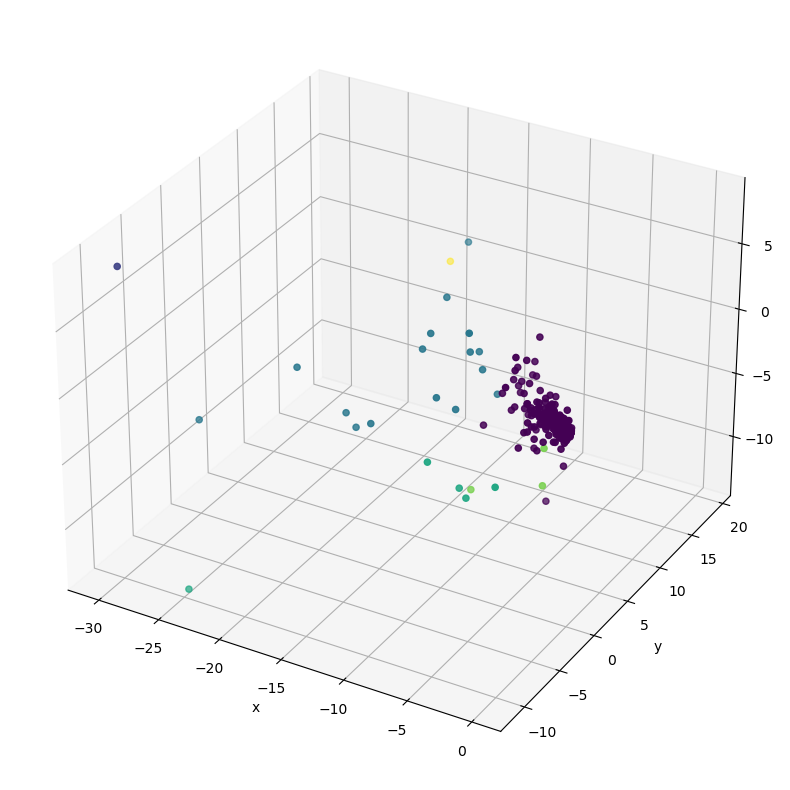

In [49]:
#3D plotting 

cluster_vis= plt.figure(figsize=(10,10)).add_subplot(projection='3d')
cluster_vis.scatter(clusters.x, clusters.y, clusters.z, c=clusters.prediction)
cluster_vis.set_xlabel('x')
cluster_vis.set_ylabel('y')
cluster_vis.set_zlabel('z')